# Phase 3: Temperature-Aware Pit-Stop Modelling with Tyre-Delta Metrics

This notebook extends the pit-stop strategy modelling framework by incorporating
environmental variables and tyre degradation rate indicators. Track temperature,
air temperature, and tyre-delta metrics are introduced to capture thermal effects
on lap time evolution and pit-stop decisions.

### Objectives
- Integrate track and ambient temperature into pit-lap prediction models
- Quantify tyre degradation using pre-pit lap-time slopes (tyre-delta)
- Improve generalisation through model regularisation
- Evaluate the impact of thermal variables on pit timing and tyre selection

### Methodology Overview
- Tyre-delta is computed as the slope of lap times over the five laps preceding
  the pit-stop, estimated separately for each compound
- Temperature features are added to the feature set used in earlier phases
- Polynomial regression degree is reduced to mitigate overfitting
- Lasso regularisation is applied to penalise large coefficients

### Notes
- Analysis is restricted to dry race conditions
- Temperature data is treated as an approximate but informative proxy
- This phase represents the transition toward physics-aware strategy modelling


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
file_path = '/content/drive/MyDrive/top3_temp.csv'

In [ ]:
import pandas as pd

df = pd.read_csv(file_path)

In [ ]:
df.head()
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 520 entries, 0 to 519
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   year                     520 non-null    int64  
 1   race_name                520 non-null    object 
 2   round                    520 non-null    int64  
 3   no_of_laps               520 non-null    int64  
 4   driver_code              520 non-null    object 
 5   team_name                520 non-null    object 
 6   qualifying_position      520 non-null    int64  
 7   finishing_position       520 non-null    int64  
 8   pitstop_count            520 non-null    int64  
 9   actual_pit_lap           520 non-null    int64  
 10  starting_tyre            520 non-null    object 
 11  tyre_after_pit           509 non-null    object 
 12  avg_lap_time_before_pit  485 non-null    float64
 13  avg_lap_time_after_pit   508 non-null    float64
 14  lap_times_5_before_pit   4

,year,round,no_of_laps,qualifying_position,finishing_position,pitstop_count,actual_pit_lap,avg_lap_time_before_pit,avg_lap_time_after_pit,track_temp,air_temp
count,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,485.000000,508.000000,520.000000,520.000000
mean,2022.544231,11.769231,60.401923,5.323077,5.515385,1.996154,18.251923,95.915678,91.666375,35.370796,23.595899
std,1.131935,6.550869,9.056130,4.064917,4.808446,0.991284,10.681769,19.110219,11.357056,9.032034,4.883728
min,2021.000000,1.000000,39.000000,1.000000,1.000000,1.000000,1.000000,69.924143,69.228452,15.258621,10.621118
25%,2022.000000,6.000000,53.000000,2.000000,2.000000,1.000000,11.000000,85.767688,83.304401,29.967763,20.255921
50%,2023.000000,12.000000,58.000000,4.000000,4.000000,2.000000,17.500000,93.655810,91.661343,35.602516,23.617791
75%,2024.000000,17.000000,70.000000,7.000000,7.000000,2.000000,26.000000,102.074280,99.625426,42.267153,27.288608
max,2024.000000,24.000000,78.000000,20.000000,20.000000,7.000000,55.000000,245.276000,145.352500,54.461719,36.565854


In [ ]:
cols = df.columns.tolist()
cols.remove('year')
cols.insert(1, 'year')
df = df[cols]
df['finishing_position'] = df['finishing_position']+3


df.head(25)

KeyError: 'finishing position'

In [ ]:
import numpy as np
lap_columns = ['avg_lap_time_before_pit', 'avg_lap_time_after_pit']
race_column = 'race_name'

def fill_missing_with_median(df, group_col, target_cols):
    for col in target_cols:
        df[col] = df.groupby(group_col)[col].transform(
            lambda x: x.fillna(x.median() if not x.median() is np.nan else np.nan)
        )
    return df

df = fill_missing_with_median(df, race_column, lap_columns)



In [ ]:
import pandas as pd
import numpy as np
import re

lap_array_cols = ['lap_times_5_before_pit', 'lap_times_5_after_pit']
group_col = 'race_name'

def parse_list(x):
    """Robust converter: handles lists like '[81.2, 82.0, ...]' or '81.2,82.0,...'"""
    if pd.isna(x):
        return None

    # Remove brackets if present
    x = str(x).strip()
    x = x.replace("[", "").replace("]", "")

    # Split by comma
    nums = re.split(r'[\s,]+', x)

    # Convert to floats, ignore empty strings
    vals = []
    for n in nums:
        try:
            vals.append(float(n))
        except:
            pass

    # Valid only if length is 5
    return vals if len(vals) == 5 else None


def _fill_group_mean(series):
    """Fill missing list entries with race-wise mean array."""
    valid = [x for x in series if isinstance(x, list)]

    if len(valid) == 0:
        return series

    arr = pd.DataFrame(valid)

    # Compute mean for each lap index
    mean_array = arr.mean().tolist()

    return series.apply(lambda x: x if isinstance(x, list) else mean_array)


def list_mean_impute(df, group_col, array_cols):
    # Parse string → list
    for col in array_cols:
        df[col] = df[col].apply(parse_list)

    # Impute using race-wise group mean
    for col in array_cols:
        df[col] = df.groupby(group_col)[col].transform(lambda grp: _fill_group_mean(grp))

    # Convert back to string
    for col in array_cols:
        df[col] = df[col].apply(lambda x: str(x) if isinstance(x, list) else np.nan)

    return df


# Run imputer
df = list_mean_impute(df, group_col, lap_array_cols)



In [ ]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 520 entries, 0 to 519
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   year                     520 non-null    int64  
 1   race_name                520 non-null    object 
 2   round                    520 non-null    int64  
 3   no_of_laps               520 non-null    int64  
 4   driver_code              520 non-null    object 
 5   team_name                520 non-null    object 
 6   qualifying_position      520 non-null    int64  
 7   finishing_position       520 non-null    int64  
 8   pitstop_count            520 non-null    int64  
 9   actual_pit_lap           520 non-null    int64  
 10  starting_tyre            520 non-null    object 
 11  tyre_after_pit           509 non-null    object 
 12  avg_lap_time_before_pit  520 non-null    float64
 13  avg_lap_time_after_pit   520 non-null    float64
 14  lap_times_5_before_pit   5

,year,round,no_of_laps,qualifying_position,finishing_position,pitstop_count,actual_pit_lap,avg_lap_time_before_pit,avg_lap_time_after_pit,track_temp,air_temp
count,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000
mean,2022.544231,11.769231,60.401923,5.323077,5.515385,1.996154,18.251923,95.612548,91.891182,35.370796,23.595899
std,1.131935,6.550869,9.056130,4.064917,4.808446,0.991284,10.681769,18.939206,11.482674,9.032034,4.883728
min,2021.000000,1.000000,39.000000,1.000000,1.000000,1.000000,1.000000,69.924143,69.228452,15.258621,10.621118
25%,2022.000000,6.000000,53.000000,2.000000,2.000000,1.000000,11.000000,85.588245,83.423227,29.967763,20.255921
50%,2023.000000,12.000000,58.000000,4.000000,4.000000,2.000000,17.500000,93.402904,91.810963,35.602516,23.617791
75%,2024.000000,17.000000,70.000000,7.000000,7.000000,2.000000,26.000000,101.923118,99.806045,42.267153,27.288608
max,2024.000000,24.000000,78.000000,20.000000,20.000000,7.000000,55.000000,245.276000,145.352500,54.461719,36.565854


In [ ]:
import pandas as pd

df = pd.read_csv(file_path)

# Convert datatypes
df = df.astype({
    'year': 'int64',
    'race_name': 'string',
    'no_of_laps': 'int64',
    'driver_code': 'string',
    'team_name': 'string',
    'pitstop_count': 'int64',
    'actual_pit_lap': 'int64',
    'starting_tyre': 'string',
    'tyre_after_pit': 'string',
    'avg_lap_time_before_pit': 'float64',
    'avg_lap_time_after_pit': 'float64',
    'lap_times_5_before_pit': 'string',
    'lap_times_5_after_pit': 'string'
})

# nullable integer types for columns that may have missing data
df['qualifying_position'] = df['qualifying_position'].astype('Int64')
df['finishing_position'] = df['finishing_position'].astype('Int64')

print(df.dtypes)


year                                int64
race_name                  string[python]
round                               int64
no_of_laps                          int64
driver_code                string[python]
team_name                  string[python]
qualifying_position                 Int64
finishing_position                  Int64
pitstop_count                       int64
actual_pit_lap                      int64
starting_tyre              string[python]
tyre_after_pit             string[python]
avg_lap_time_before_pit           float64
avg_lap_time_after_pit            float64
lap_times_5_before_pit     string[python]
lap_times_5_after_pit      string[python]
track_temp                        float64
air_temp                          float64
dtype: object


In [ ]:
print(df.isna().sum())


year                       0
race_name                  0
round                      0
no_of_laps                 0
driver_code                0
team_name                  0
qualifying_position        0
finishing_position         0
pitstop_count              0
actual_pit_lap             0
starting_tyre              0
tyre_after_pit             0
avg_lap_time_before_pit    0
avg_lap_time_after_pit     0
lap_times_5_before_pit     6
lap_times_5_after_pit      0
track_temp                 0
air_temp                   0
dtype: int64


In [ ]:
import numpy as np

# Calculate derived features
df['lap_time_diff'] = df['avg_lap_time_after_pit'] - df['avg_lap_time_before_pit']
df['pit_effectiveness'] = df['lap_time_diff'] / df['pitstop_count']

# Tyre compound change
df['tyre_change'] = np.where(df['starting_tyre'] != df['tyre_after_pit'], 1, 0)

# Position gain/loss
df['position_gain'] = df['qualifying_position'] - df['finishing_position']

# Undercut success flag
df['is_undercut_successful'] = (df['lap_time_diff'] < 0) & (df['position_gain'] > 0)

# Normalized performance gain
df['avg_lap_improvement_ratio'] = (
    (df['avg_lap_time_before_pit'] - df['avg_lap_time_after_pit'])
    / df['avg_lap_time_before_pit']
)

# Tyre strategy score (SOFT > MEDIUM > HARD)
def tyre_score(before, after):
    mapping = {'SOFT': 3, 'MEDIUM': 2, 'HARD': 1}
    if pd.isna(before) or pd.isna(after):
        return np.nan
    return mapping.get(before, 0) - mapping.get(after, 0)

df['tyre_strategy_score'] = df.apply(
    lambda row: tyre_score(row['starting_tyre'], row['tyre_after_pit']), axis=1
)

# Check new columns
df.head()


,year,race_name,round,no_of_laps,driver_code,team_name,qualifying_position,finishing_position,pitstop_count,actual_pit_lap,...,lap_times_5_after_pit,track_temp,air_temp,lap_time_diff,pit_effectiveness,tyre_change,position_gain,is_undercut_successful,avg_lap_improvement_ratio,tyre_strategy_score
0,2021,Bahrain Grand Prix,1,56,HAM,Mercedes,2,1,2,13,...,"[115.006, 94.057, 95.104, 95.099, 95.266]",27.62782,20.538346,-8.264662,-4.132331,1,1,True,0.079359,1
1,2021,Bahrain Grand Prix,1,56,VER,Red Bull Racing,1,2,2,17,...,"[115.532, 94.421, 94.87, 94.829, 95.159]",27.62782,20.538346,-6.132359,-3.066179,0,-1,False,0.060136,0
2,2021,Bahrain Grand Prix,1,56,BOT,Mercedes,3,3,3,16,...,"[114.719, 95.038, 94.518, 94.774, 95.098]",27.62782,20.538346,-6.410504,-2.136835,1,0,False,0.062216,1
3,2021,Bahrain Grand Prix,1,56,PER,Red Bull Racing,11,5,3,2,...,"[135.246, 118.724, 100.01, 97.48, 97.891]",27.62782,20.538346,-50.037537,-16.679179,0,6,True,0.338203,0
4,2021,Bahrain Grand Prix,1,56,LEC,Ferrari,4,6,2,12,...,"[116.773, 95.552, 95.955, 96.415, 96.936]",27.62782,20.538346,-9.355241,-4.677620,1,-2,False,0.088027,1


In [ ]:
tyre_column = 'tyre_after_pit'

df[tyre_column] = df[tyre_column].fillna(method='ffill')

print(df[tyre_column].isna().sum())


0


/tmp/ipython-input-4101662684.py:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[tyre_column] = df[tyre_column].fillna(method='ffill')


In [ ]:

relevant_tyres = ['SOFT', 'MEDIUM', 'HARD']
df_train = df[
    df['starting_tyre'].isin(relevant_tyres) &
    df['tyre_after_pit'].isin(relevant_tyres)
].copy()



In [ ]:
df['laps_since_pit'] = df['no_of_laps'] - df['actual_pit_lap']



 Training model for tyre: HARD
RMSE for HARD: 4.7589


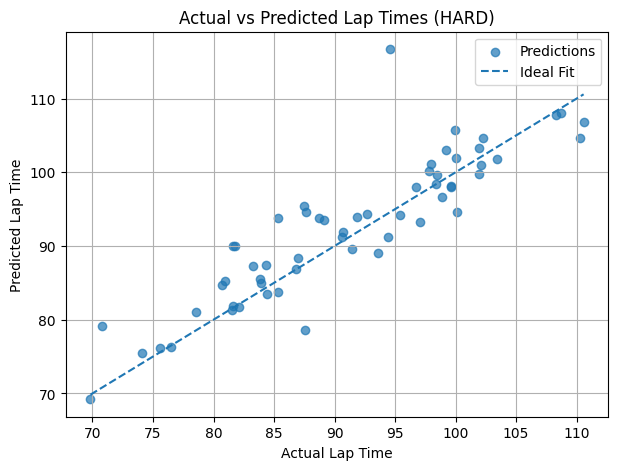

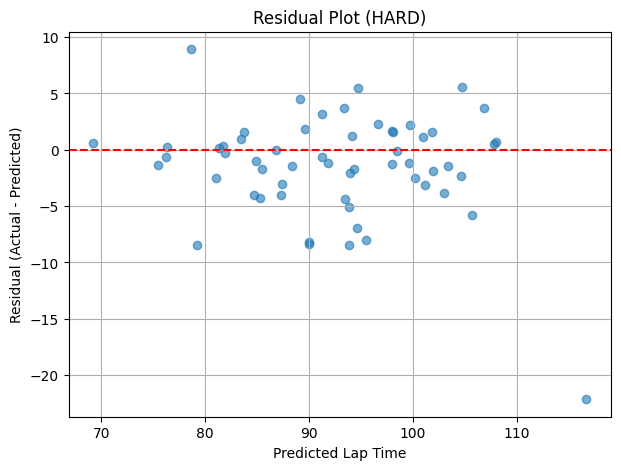

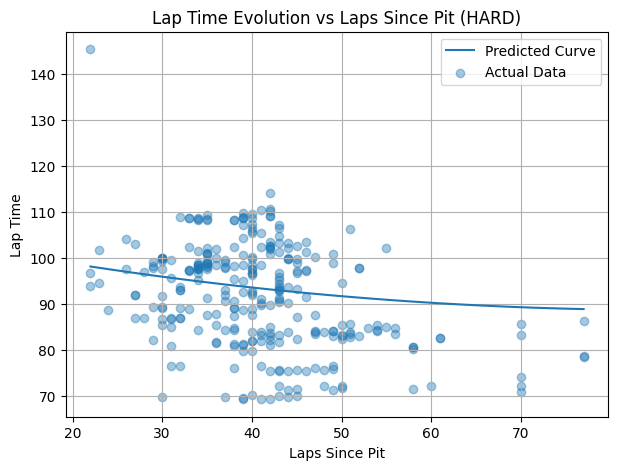


 Training model for tyre: MEDIUM
RMSE for MEDIUM: 5.4314


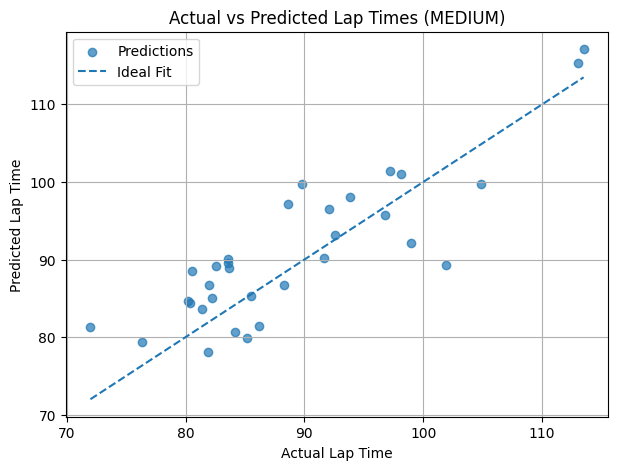

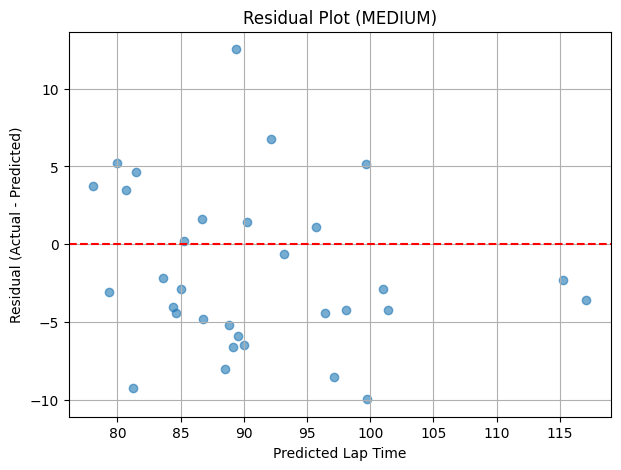

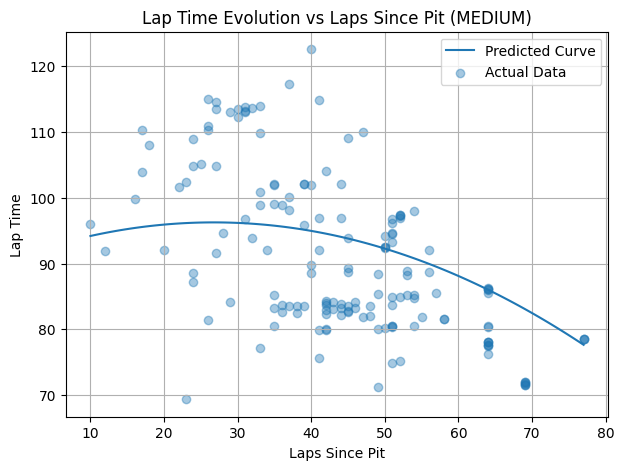


 Training model for tyre: SOFT
RMSE for SOFT: 2.1419


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.660e-01, tolerance: 2.120e-01
  model = cd_fast.enet_coordinate_descent(


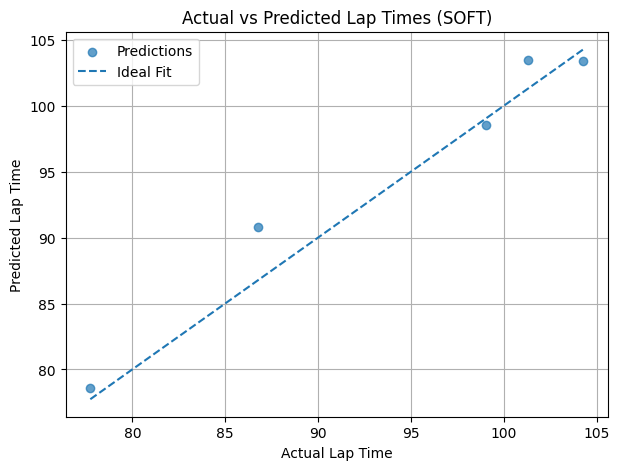

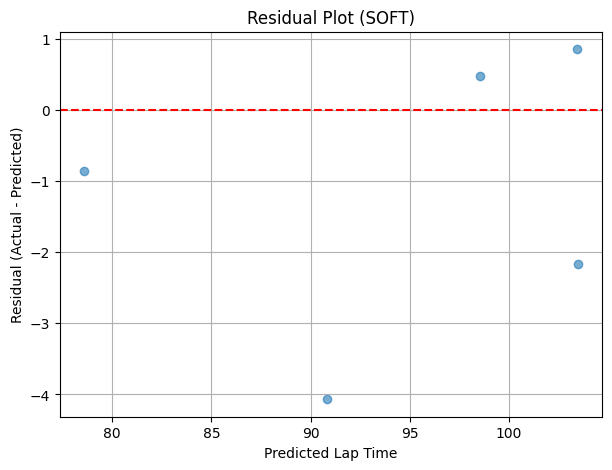

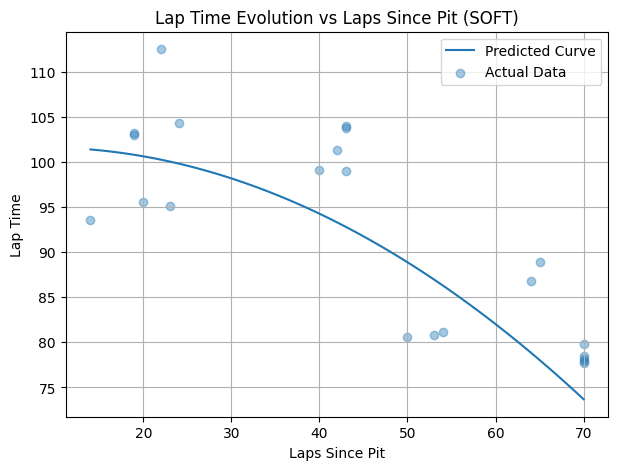


 Training model for tyre: INTERMEDIATE
RMSE for INTERMEDIATE: 6.2366


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.925e-01, tolerance: 2.853e-01
  model = cd_fast.enet_coordinate_descent(


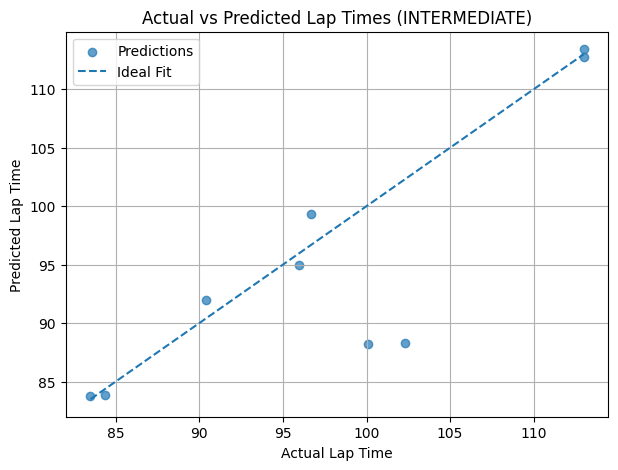

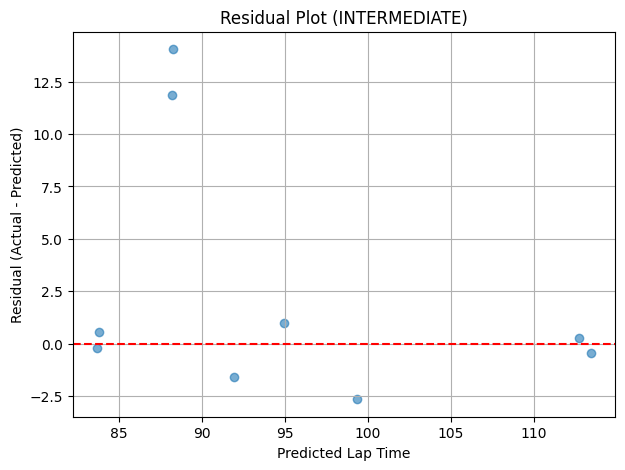

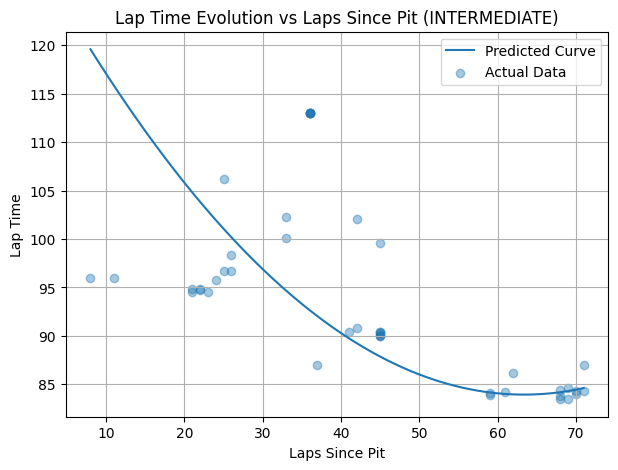


 Training model for tyre: WET
 Too little data for WET. Skipping.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# ----------------------------
# CONFIG
# ----------------------------
degree = 2
alpha = 0.001  # Lasso regularization strength
tyres = df["tyre_after_pit"].unique()

# Feature list
features = [
    "laps_since_pit",
    "avg_lap_time_before_pit",
    "air_temp",
    "track_temp"
]

target_col = "avg_lap_time_after_pit"

poly_models = {}

# ----------------------------
# TRAIN PER-TYRE MODELS
# ----------------------------
for tyre in tyres:
    print(f"\n Training model for tyre: {tyre}")

    tyre_df = df[df["tyre_after_pit"] == tyre].dropna(subset=features + [target_col])

    if len(tyre_df) < 20:
        print(f" Too little data for {tyre}. Skipping.")
        continue

    X = tyre_df[features].values
    y = tyre_df[target_col].values

    # Standardize before polynomial expansion
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Polynomial features (degree=2)
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    X_poly = poly.fit_transform(X_scaled)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_poly, y, test_size=0.2, random_state=42
    )

    # Lasso model
    model = Lasso(alpha=alpha, max_iter=10000)
    model.fit(X_train, y_train)

    # Predictions
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"RMSE for {tyre}: {rmse:.4f}")

    # Store model
    poly_models[tyre] = {
        "model": model,
        "poly": poly,
        "scaler": scaler,
        "rmse": rmse
    }

    # -------------------------------------------------------
    # VISUALISATION 1 — Actual vs Predicted Scatter Plot
    # -------------------------------------------------------
    plt.figure(figsize=(7, 5))
    plt.scatter(y_test, y_pred, label="Predictions", alpha=0.7)
    plt.plot([min(y_test), max(y_test)],
             [min(y_test), max(y_test)],
             linestyle='--', label="Ideal Fit")
    plt.title(f"Actual vs Predicted Lap Times ({tyre})")
    plt.xlabel("Actual Lap Time")
    plt.ylabel("Predicted Lap Time")
    plt.legend()
    plt.grid(True)
    plt.show()

    # -------------------------------------------------------
    # VISUALISATION 2 — Residual Plot
    # -------------------------------------------------------
    residuals = y_test - y_pred

    plt.figure(figsize=(7, 5))
    plt.scatter(y_pred, residuals, alpha=0.6)
    plt.axhline(0, color='red', linestyle='--')
    plt.title(f"Residual Plot ({tyre})")
    plt.xlabel("Predicted Lap Time")
    plt.ylabel("Residual (Actual - Predicted)")
    plt.grid(True)
    plt.show()

    # -------------------------------------------------------
    # VISUALISATION 3 — Effect of Laps Since Pit (1D Slice)
    # -------------------------------------------------------
    # Fix: avg_before, air_temp, track temp at median
    medians = np.median(X, axis=0)
    ls_range = np.linspace(X[:, 0].min(), X[:, 0].max(), 100)

    X_slice = np.array([
        [ls, medians[1], medians[2], medians[3]]
        for ls in ls_range
    ])

    X_slice_scaled = scaler.transform(X_slice)
    X_slice_poly = poly.transform(X_slice_scaled)
    y_slice_pred = model.predict(X_slice_poly)

    plt.figure(figsize=(7, 5))
    plt.plot(ls_range, y_slice_pred, label="Predicted Curve")
    plt.scatter(X[:, 0], y, alpha=0.4, label="Actual Data")
    plt.title(f"Lap Time Evolution vs Laps Since Pit ({tyre})")
    plt.xlabel("Laps Since Pit")
    plt.ylabel("Lap Time")
    plt.grid(True)
    plt.legend()
    plt.show()



In [ ]:
import numpy as np
import pandas as pd
import ast

# Parse the 5-lap arrays
def safe_mean(x):
    if pd.isna(x):
        return np.nan
    try:
        arr = ast.literal_eval(x)
        return np.mean(arr) if isinstance(arr, list) else np.nan
    except:
        return np.nan

df['mean_5_before'] = df['lap_times_5_before_pit'].apply(safe_mean)
df['mean_5_after']  = df['lap_times_5_after_pit'].apply(safe_mean)

# Tyre degradation metrics
df['deg_5lap'] = df['mean_5_after'] - df['mean_5_before']
df['lap_delta'] = df['avg_lap_time_after_pit'] - df['avg_lap_time_before_pit']

# Stint slope degradation (optional)
df['deg_slope'] = df['deg_5lap'] / df['laps_since_pit']
df['deg_slope'] = df['deg_slope'].replace([np.inf, -np.inf], np.nan).fillna(0)

# Ensure no missing
df.fillna(0, inplace=True)


In [ ]:
df.columns


Index(['year', 'race_name', 'round', 'no_of_laps', 'driver_code', 'team_name',
       'qualifying_position', 'finishing_position', 'pitstop_count',
       'actual_pit_lap', 'starting_tyre', 'tyre_after_pit',
       'avg_lap_time_before_pit', 'avg_lap_time_after_pit',
       'lap_times_5_before_pit', 'lap_times_5_after_pit', 'track_temp',
       'air_temp', 'lap_time_diff', 'pit_effectiveness', 'tyre_change',
       'position_gain', 'is_undercut_successful', 'avg_lap_improvement_ratio',
       'tyre_strategy_score', 'laps_since_pit', 'starting_tyre_HARD',
       'starting_tyre_INTERMEDIATE', 'starting_tyre_MEDIUM',
       'starting_tyre_SOFT', 'starting_tyre_UNKNOWN', 'starting_tyre_WET',
       'mean_5_before', 'mean_5_after', 'deg_5lap', 'lap_delta', 'deg_slope',
       'tyreB_HARD', 'tyreB_INTERMEDIATE', 'tyreB_MEDIUM', 'tyreB_SOFT',
       'tyreB_UNKNOWN', 'tyreB_WET'],
      dtype='object')

In [ ]:
df = df.sort_values(['year', 'race_name', 'driver_code'])

# Get list of pit laps per driver per race
pit_dict = (
    df[df['actual_pit_lap'].notna()]
    .groupby(['year', 'race_name', 'driver_code'])['actual_pit_lap']
    .apply(list)
    .to_dict()
)


In [ ]:
def get_next_pit(row):
    key = (row['year'], row['race_name'], row['driver_code'])
    laps = pit_dict.get(key, [])

    # Find the FIRST pit lap that is greater than "laps_since_pit"
    current_lap = row['laps_since_pit']

    for lap in laps:
        if lap > current_lap:
            return lap

    return np.nan   # no next pit (like 1-stop races)


In [ ]:
df['next_pit_lap'] = df.apply(get_next_pit, axis=1)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.057e+01, tolerance: 1.614e-01
  model = cd_fast.enet_coordinate_descent(



🔵 PIT LAP PREDICTOR RMSE = 9.766


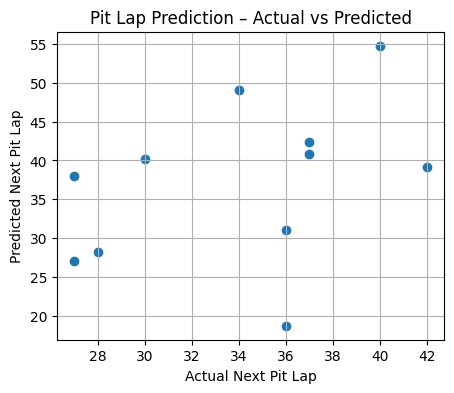

In [ ]:
#included tyre delta
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

# POLY + LASSO
degree = 2
alpha = 0.0001

# ------------ FEATURES FOR PIT LAP PREDICTOR ------------
pit_features = [
    'laps_since_pit',
    'avg_lap_time_before_pit',
    'deg_5lap',
    'deg_slope',
    'air_temp',
    'track_temp',
    'pitstop_count'
]

# INCLUDE TYRE BEFORE PIT AS ONE-HOT
tyre_before_encoded = pd.get_dummies(df['starting_tyre'], prefix='tyreB')
df = pd.concat([df, tyre_before_encoded], axis=1)
pit_features += list(tyre_before_encoded.columns)

# Remove NaNs
pit_df = df.dropna(subset=pit_features + ['next_pit_lap'])

X = pit_df[pit_features].values
y = pit_df['next_pit_lap'].values

poly = PolynomialFeatures(degree=degree)
X_poly = poly.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_poly, y, test_size=0.2, random_state=42)

model_pitlap = Lasso(alpha=alpha)
model_pitlap.fit(X_train, y_train)

pred = model_pitlap.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, pred))
print(f"\n PIT LAP PREDICTOR RMSE = {rmse:.3f}")

# ------------ VISUALIZATION ------------
plt.figure(figsize=(5,4))
plt.scatter(y_test, pred)
plt.xlabel("Actual Next Pit Lap")
plt.ylabel("Predicted Next Pit Lap")
plt.title("Pit Lap Prediction – Actual vs Predicted")
plt.grid()
plt.show()


In [ ]:
from sklearn.preprocessing import OneHotEncoder

# Make sure original 'starting_tyre' exists
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
tyre_encoded = encoder.fit_transform(df[['starting_tyre']])
tyre_encoded_df = pd.DataFrame(tyre_encoded, columns=encoder.get_feature_names_out(['starting_tyre']))
df = pd.concat([df.reset_index(drop=True), tyre_encoded_df.reset_index(drop=True)], axis=1)


Tyre Classifier Accuracy: 0.769


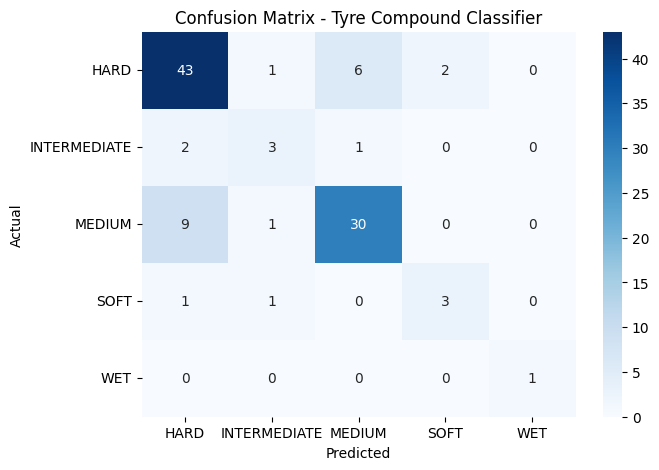

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Features for classifier
features = ['laps_since_pit', 'pitstop_count'] + list(tyre_encoded_df.columns)
X_cls = df[features]
y_cls = df['tyre_after_pit']

# Train-test split
X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(
    X_cls, y_cls, test_size=0.2, random_state=42
)

# Model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_cls, y_train_cls)

# Predictions
y_pred_cls = clf.predict(X_test_cls)
accuracy = accuracy_score(y_test_cls, y_pred_cls)
print(f"Tyre Classifier Accuracy: {accuracy:.3f}")

# -------------------------------------
# CONFUSION MATRIX
# -------------------------------------
cm = confusion_matrix(y_test_cls, y_pred_cls, labels=clf.classes_)

plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=clf.classes_,
            yticklabels=clf.classes_)
plt.title("Confusion Matrix - Tyre Compound Classifier")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()



In [ ]:
# Example values — replace with actual data from your race simulation
current_laps_since_pit = 5          # e.g., 5 laps since last pit
current_pitstop_count = 1           # how many pitstops already done

# Starting tyre one-hot encoding (assume currently on MEDIUM tyre)
starting_tyre_HARD = 0
starting_tyre_MEDIUM = 1
starting_tyre_SOFT = 0
starting_tyre_WET = 0
starting_tyre_INTERMEDIATE = 0

X_cls_input = [[
    current_laps_since_pit,
    current_pitstop_count,
    # plus starting_tyre one-hot encoding
    starting_tyre_HARD,
    starting_tyre_MEDIUM,
    starting_tyre_SOFT,
    starting_tyre_WET,
    starting_tyre_INTERMEDIATE
]]

next_tyre = clf.predict(X_cls_input)[0]
print("Recommended Tyre:", next_tyre)

# Get the polynomial model for the selected tyre
poly_model = poly_models[next_tyre]

# Build feature matrix for future laps
future_laps_since_pit = np.arange(1, 21)
X_future = np.column_stack((
    future_laps_since_pit,
    np.full_like(future_laps_since_pit, last_avg_lap_time),

))

X_future_poly = poly_model['poly'].transform(X_future)
predicted_laptimes = poly_model['regressor'].predict(X_future_poly)
print("Predicted Lap Times for next stint:", predicted_laptimes)



/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


ValueError: X has 7 features, but RandomForestClassifier is expecting 8 features as input.